# Plotting indicators for SVI data

## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, r2_score, mean_absolute_percentage_error
from scipy import stats


## Read and filter the data, based on the kept columns Jose suggested

In [7]:
# SVI Filtered Indicators for performing the PCA on Minnesota
df = pd.read_csv("p-value_filtered_SVI.csv")

# get the y values of f-values and weighted f-values from the data
fvalues = df.get("F.values")
# 
wfvalues = df.get("Weighted.f.values")

# get values for SVI and f-values for the interactive map
df2 = pd.read_csv("svi_interactive_map.csv")
testfvalues = pd.read_csv("Filtered_F_Values.csv")


fipsmerge = df2.merge(testfvalues, on='FIPS', how='outer').drop(columns="Unnamed: 0").dropna(subset=['F_VALUE'])
Minn = fipsmerge[fipsmerge['STATE'] == 'Minnesota']
fips= fipsmerge["FIPS"].apply(str)
fips = pd.DataFrame([s.zfill(5) for s in fips])
fips = fips.rename(columns={0: "FIPS"})
testfvalues = fipsmerge.get("F_VALUE")
fipsmerge.drop(columns=["F_VALUE"])
# drop these columns, as they aren't part of the PCA but rather the outputs for regression
df = df.drop(columns=["F.values", "Weighted.f.values"])

# Keeping the columns that Jose mentioned for our analysis
keep = ["E_HH", "EP_POV150", "E_NOHSDP", "E_UNINSUR", "EP_MINRTY", "E_SNGPNT", "E_GROUPQ", "EP_MUNIT", "E_UNEMP", "E_DISABL", "E_TOTPOP", "E_AGE65","E_AGE17", "E_LIMENG", "E_CROWD", "E_NOVEH", "E_DAYPOP" , "E_NOINT"]
keeploc = ["E_HH", "EP_POV150", "E_NOHSDP", "E_UNINSUR", "EP_MINRTY", "E_SNGPNT", "E_GROUPQ", "EP_MUNIT", "E_UNEMP", "E_DISABL", "E_TOTPOP", "E_AGE65","E_AGE17", "E_LIMENG", "E_CROWD", "E_NOVEH", "E_DAYPOP" , "E_NOINT"]

# Minnesota information so that we can run plots for indicators, etc.
minn_f = Minn["F_VALUE"]
Minn = Minn.drop(columns=["F_VALUE"])

# Use these as stored 
kept = df[keep]
all_kept = fipsmerge[keep]

In [ ]:
thres = 84.46
components = "kept"

## Constructing the Linear Regression model from the threshold amount, to get the eigenvalues used for calculating the components.

In [ ]:
if components == "kept":
    data = kept
    expl_var = expl_var_kept
else: 
    data = df
    expl_var = expl_var_all
print(data["E_UNEMP"])
num_components = 0
for i in range(len(expl_var)):
    if expl_var[i] >= thres:
        num_components = i+1
        break
if num_components == 0:
    num_components = len(expl_var)
#print ("Labels for the components: " + str(list(data.columns)))
#print("Number of components based on threshold (>="+str(thres)+"%): "+str(num_components))
pca = PCA(num_components)
X_train = pca.fit_transform(scale(data))
#print(X_train)

ranked = sorted(zip(list(data.columns), pca.components_.tolist()[0]), key=lambda x: abs(x[1]))
print("Ranked labels of VSIs based on eigenvectors associated with the components constructed for the component analysis:")
print([j[0] for j in ranked][::-1])
print("The eigenvalues: " + str(sorted(pca.components_.tolist()[0], key=lambda x: abs(x))[::-1]))

## Gabby you can edit these to get predicted f-values and test f-values

R^2: -0.5805977329279455
RMSE: 1.2572182519069415
MAPE: 11.157887581186671
      EP_MINRTY
1315        6.3
1317       14.4
1318       28.4
1319       11.1
1320        3.8
...         ...
1395       11.0
1396       18.3
1398        7.1
1399        9.1
1400        8.2

[72 rows x 1 columns]
1315   -0.002853
1317    0.074415
1318    0.111405
1319   -0.005113
1320    0.002779
          ...   
1395   -0.008140
1396   -0.038467
1398    0.000929
1399    0.012733
1400   -0.050212
Name: F_VALUE, Length: 72, dtype: float64


/home/anvitha/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


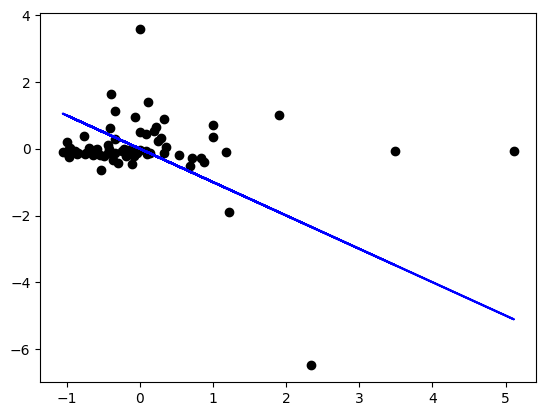

In [8]:
#train PCR model on training data "E_UNEMP","EP_MINRTY",, "E_UNEMP", "EP_POV150"
indicators = ["EP_MINRTY"]

## finding the indicators for minnesota based on the filtered ones 
X1 = Minn[indicators]

# Training set for linear regression
train = X1

regr1 = LinearRegression()

# scaling data before running linreg because PCA used scaled data?
regr1.fit(scale(train), scale(minn_f))

# actual f-values for minnesota
testfvalues = scale(minn_f)

# predicted values based on regression
predfvalues = scale(regr1.predict(train))


# correlation indicators:
print("R^2: " + str(r2_score(scale(testfvalues),predfvalues)))
#calculate RMSE
print("RMSE: " + str(np.sqrt(mean_squared_error(testfvalues, predfvalues))))
# calculate MAPE
print("MAPE: " + str(mean_absolute_percentage_error(testfvalues, predfvalues)))

#sanity checking data
#print(X1)
#print(minn_f)
plt.scatter(scale(X1), scale(testfvalues), color="black")
plt.plot(scale(X1), scale(predfvalues), color="blue")
#plt.plot(scale(np.array(keptfipsmerge[indicators])), scale(predfvalues), color="red")


In [ ]:
print("predicted range: "+ str() + " " + str(max(predfvalues)))
print("actual range: "+ str(min(testfvalues)) + " " + str(max(testfvalues)))
predfvalues = scale(predfvalues)
testfvalues = scale(testfvalues)
from scipy.interpolate import interp1d
rangepred = interp1d([min(predfvalues),max(predfvalues)],[-10,10])
rangetest = interp1d([min(testfvalues),max(testfvalues)],[-10,10])
print(pd.DataFrame(testfvalues).apply(lambda x: rangetest(x)))

testf = pd.DataFrame()
testf['FIPS'] = fips
testf['F-VALUES'] = pd.DataFrame(testfvalues).apply(lambda x: rangetest(x))
predf = pd.DataFrame()
predf['FIPS'] = fips
predf['F-VALUES'] =pd.DataFrame(predfvalues).apply(lambda x: rangepred(x))
print(testf)
print(predf)
testf.to_csv("actual_odin.csv", index=False)
predf.to_csv("predicted_odin_all.csv", index=False)
